In [29]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import math


https://naif.jpl.nasa.gov/naif/Ancillary_Data_Production_v2.pdf

In [ ]:
# https://naif.jpl.nasa.gov/naif/aboutspice.html
import spiceypy as spice

### Get Data

In [ ]:
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/

def load_kernels():
    spice.furnsh("../data/naif0012.tls")      # Leap seconds - conversion of earth time to ephemeris time
    spice.furnsh("../data/de440s.bsp")        # Ephemeris data - position and velocities
    spice.furnsh("../data/pck00011.tpc")      # Planetary constants - radius, spin axes, rotation rates etc.

### Get Angle between 2 Vectors

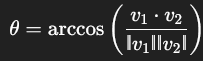

In [ ]:
def get_angle_between_vectors(v1, v2):
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        raise ValueError("One of the vectors has zero length")
    cos_theta = dot / (norm1 * norm2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.arccos(cos_theta)
    # return spice.vsep(v1, v2)

### Get Angular Distance

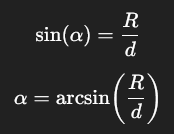

In [ ]:
# Get angular radius (how big a body of given radius looks from given distance) - values clamped [0,1]
def get_angular_radius(radius_km, dist_km):
    x = max(0.0, min(1.0, radius_km / max(dist_km, 1e-9)))
    return math.asin(x)

### Get Radius

SPICE stores 3 radii (across x, y, z) - as things are not perfect spheres, so we take a mean of the 3  

In [ ]:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/IDL/icy/cspice_bodvrd.html
def get_mean_radius_km(body_name):
    radii = spice.bodvrd(body_name.upper(), "RADII", 3)[1]
    return float(np.mean(radii))

### Get State Vector

In [ ]:
 def get_state_vec(targ, obs, et, ref="J2000"):
    state, lt = spice.spkgeo(targ=targ, et=et, ref=ref, obs=obs)
    return np.array(state[:3])

### Get Separation over time range

In [ ]:
def solar_moon_separation_over_range(start_date, end_date, step_hours=6):
    """Sun–Moon angular separation (as seen from Earth’s center) over time."""
    ets, seps_deg, dates = [], [], []
    t = start_date
    while t <= end_date:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        # Vectors from Earth to Sun and Moon:
        r_es = state_vec(10, 399, et)     # Sun wrt Earth
        r_em = state_vec(301, 399, et)    # Moon wrt Earth
        sep = ang(r_es, r_em) * DEG
        ets.append(et); seps_deg.append(sep); dates.append(t)
        t += timedelta(hours=step_hours)
    return np.array(ets), np.array(seps_deg), dates

### Get Eclipse Candidate

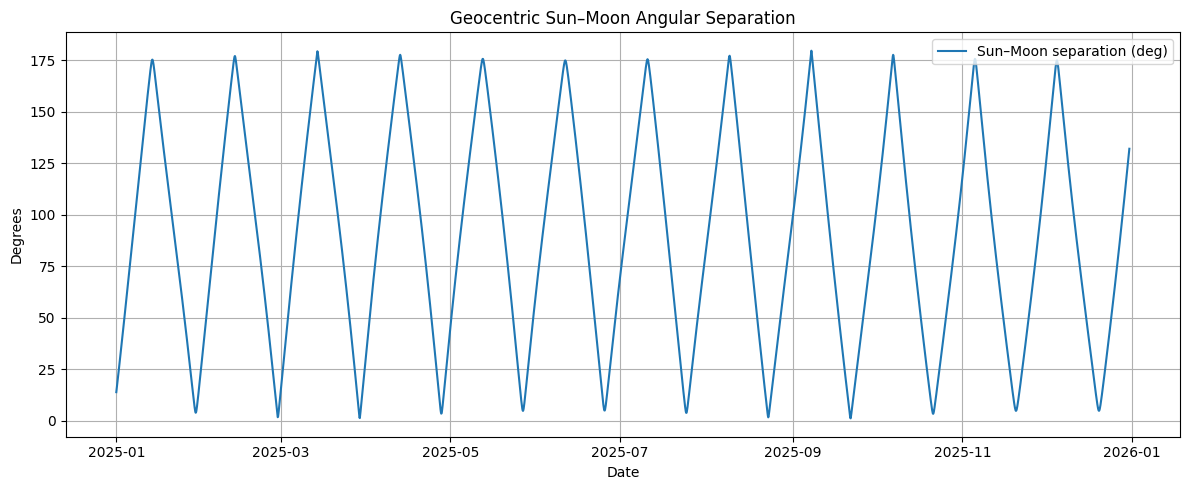


=== Solar eclipse CANDIDATE timestamps (geocenter heuristic) ===
None at current threshold / cadence.

=== Lunar eclipse CANDIDATE windows (umbra criterion at Moon) ===
None at current tolerance / cadence.


In [ ]:
def lunar_eclipse_candidates(start_date, end_date, step_hours=2, tol_deg=0.8):
    """
    Very reasonable lunar-eclipse test (umbra criterion, geocentric):
    At the Moon, compare angular radius of Earth versus Sun.
    If Moon is near the anti-solar direction of Earth and Earth’s apparent radius
    exceeds Sun’s by some margin, we flag a candidate.
    """
    dates, flags = [], []
    t = start_date

    # Body mean radii (km)
    R_earth = mean_radius_km("EARTH")
    R_sun   = mean_radius_km("SUN")

    while t <= end_date:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        # Positions wrt Moon:
        r_me = -state_vec(301, 399, et)               # Earth wrt Moon = negative of Moon wrt Earth
        r_ms =  state_vec(10, 301, et)                # Sun wrt Moon

        # Distances
        d_me = np.linalg.norm(r_me)                   # Moon->Earth
        d_ms = np.linalg.norm(r_ms)                   # Moon->Sun

        # Angular radii as seen from Moon
        alpha_E = angular_radius(R_earth, d_me)
        alpha_S = angular_radius(R_sun,   d_ms)

        # Angle between anti-solar direction and Earth direction as seen from Moon
        # Anti-solar vector at Moon is -r_ms; compare it to r_me
        theta = ang(r_me, -r_ms) * DEG

        # Heuristic: alignment within tol_deg and Earth's apparent radius >= Sun's ⇒ umbral possibility
        is_candidate = (theta < tol_deg) and (alpha_E > alpha_S)
        dates.append(t); flags.append(is_candidate)
        t += timedelta(hours=step_hours)

    # Collapse contiguous runs to date windows
    windows = []
    active = False; start = None
    for i, flag in enumerate(flags):
        if flag and not active:
            active = True; start = dates[i]
        if active and (not flag or i == len(flags)-1):
            end = dates[i] if flag else dates[i-1]
            windows.append((start, end))
            active = False
    return windows




### Get Simulation

In [ ]:
# ---------- Driver & plots ----------
def run_sim(start="2025-01-01", stop="2025-12-31",
            solar_sep_threshold_deg=0.6, sep_step_hours=6):
    load_kernels()
    start_date = datetime.fromisoformat(start)
    end_date   = datetime.fromisoformat(stop)

    # Solar eclipse candidates by small Sun–Moon separation (geocentric)
    ets, seps_deg, dates = solar_moon_separation_over_range(
        start_date, end_date, step_hours=sep_step_hours
    )
    # Candidate timestamps
    solar_idx = np.where(seps_deg < solar_sep_threshold_deg)[0]
    solar_dates = [dates[i] for i in solar_idx]

    # Lunar eclipse candidates via umbra criterion at Moon
    lunar_windows = lunar_eclipse_candidates(
        start_date, end_date, step_hours=2, tol_deg=0.8
    )

    # Plot Sun–Moon separation
    plt.figure(figsize=(12, 5))
    plt.plot(dates, seps_deg, label="Sun–Moon separation (deg)")
    if len(solar_idx):
        y = [solar_sep_threshold_deg]*len(dates)
        plt.axhline(solar_sep_threshold_deg, linestyle="--", label="Solar eclipse threshold")
    plt.title("Geocentric Sun–Moon Angular Separation")
    plt.xlabel("Date"); plt.ylabel("Degrees"); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

    print("\n=== Solar eclipse CANDIDATE timestamps (geocenter heuristic) ===")
    if not solar_dates:
        print("None at current threshold / cadence.")
    else:
        for d in solar_dates:
            print(d.strftime("%Y-%m-%d %H:%M"))

    print("\n=== Lunar eclipse CANDIDATE windows (umbra criterion at Moon) ===")
    if not lunar_windows:
        print("None at current tolerance / cadence.")
    else:
        for (a, b) in lunar_windows:
            print(f"{a.strftime('%Y-%m-%d %H:%M')}  →  {b.strftime('%Y-%m-%d %H:%M')}")



### Run Simulation

In [ ]:
run_sim(start="2025-01-01", stop="2025-12-31",
            solar_sep_threshold_deg=0.6, sep_step_hours=3)